# Testing the Classifier

In this notebook we will test the classifier trained with vector search on a set of images.

First we initialize our new classifier, CLIP, and the `imagenette` dataset.

In [1]:
import torch

with open("classifier.pth", "rb") as f:
    clf = torch.load(f)

In [2]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

clip = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

We load the **valudation** split from imagenette.

In [3]:
from datasets import load_dataset

imagenet = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='validation',
    ignore_verifications=False  # set to True if seeing splits Error
)
imagenet

Reusing dataset imagenette (/Users/jamesbriggs/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

We'll start by checking the predictions for some specific images...

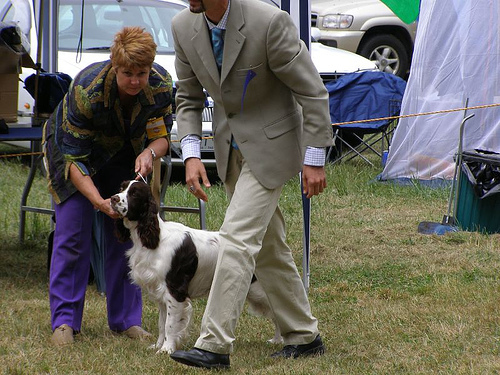

In [4]:
i = 2397  # 2386
imagenet[i]['image']

In [5]:
image = processor(
    text=None,
    images=imagenet[i]['image'],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)

In [6]:
out = clip.get_image_features(pixel_values=image)
out.shape

torch.Size([1, 512])

In [7]:
clf(out)

tensor([[5.3055]], grad_fn=<AddmmBackward0>)

The prediction is > 0, meaning this is predicted as positive. Let's try another...

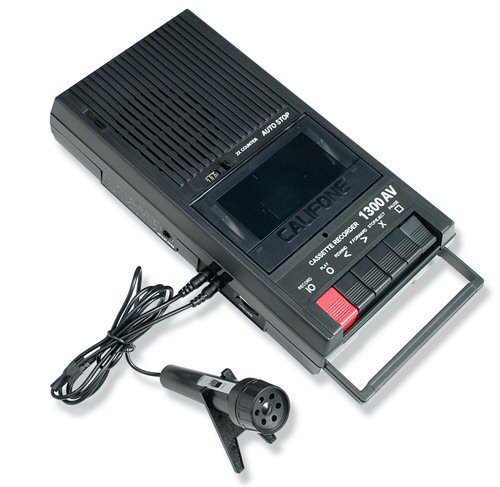

In [8]:
i = 0
imagenet[i]['image']

In [9]:
image = processor(
    text=None,
    images=imagenet[i]['image'],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)

out = clip.get_image_features(pixel_values=image)

clf(out)

tensor([[-12.6166]], grad_fn=<AddmmBackward0>)

We can label the full the dataset and find the cut-off point between what is viewed as relevant and what is not.

In [10]:
from tqdm.auto import tqdm

batch_size = 64

preds = []

for i in tqdm(range(0, len(imagenet), batch_size)):
    i_end = min(i+batch_size, len(imagenet))
    image = processor(
        text=None,
        images=imagenet[i:i_end]['image'],
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    out = clip.get_image_features(pixel_values=image)
    logits = clf(out)
    preds.extend(logits.detach().cpu().numpy().reshape(1, -1)[0].tolist())

  0%|          | 0/62 [00:00<?, ?it/s]

Add the predictions to `imagenet`.

In [11]:
# add the predictions to the dataset
imagenet = imagenet.add_column('preds', preds)
imagenet

Dataset({
    features: ['image', 'label', 'preds'],
    num_rows: 3925
})

Filter out any results where the prediction is not positive.

In [12]:
# filter out negative predictions
positives = imagenet.filter(lambda x: x['preds'] > 0.0)
len(positives)

  0%|          | 0/4 [00:00<?, ?ba/s]

23

Now let's sort the results and view the highest scored images from our classifier.

7.7753


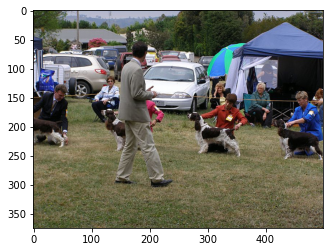

7.5057


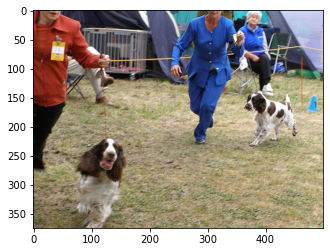

7.1774


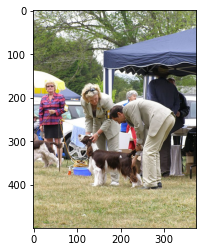

6.8365


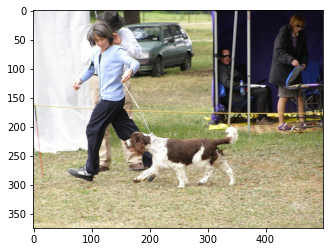

6.7447


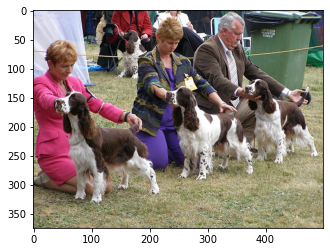

6.2452


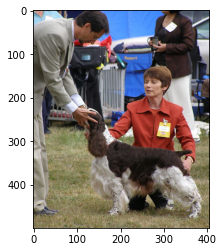

5.722


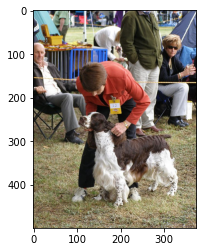

5.3055


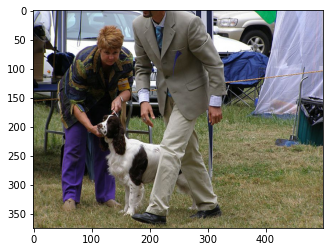

5.2923


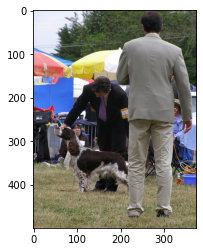

5.2382


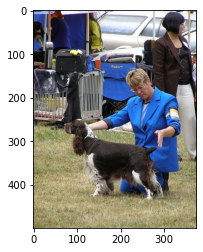

5.158


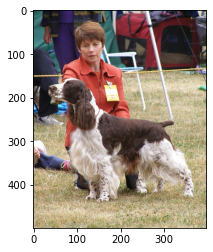

5.089


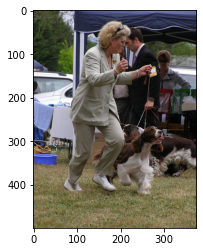

4.9458


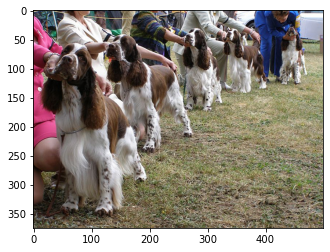

3.7833


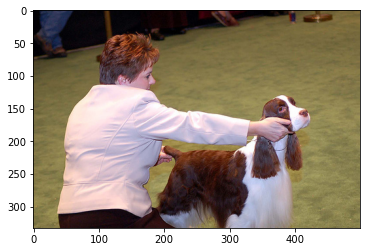

3.5814


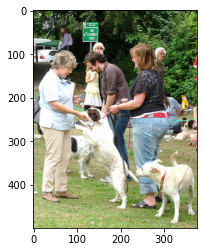

2.8633


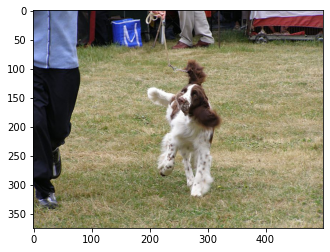

1.9756


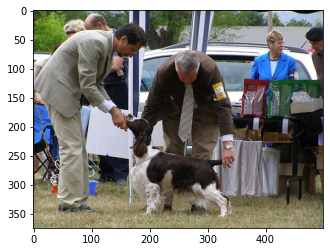

1.6325


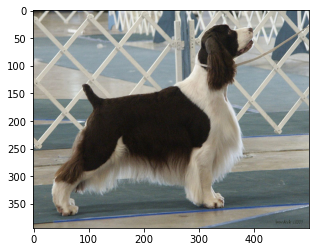

1.5163


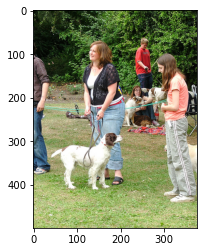

0.8474


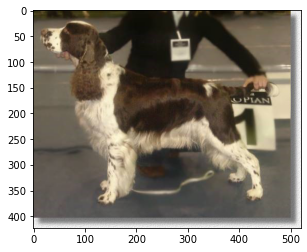

0.3282


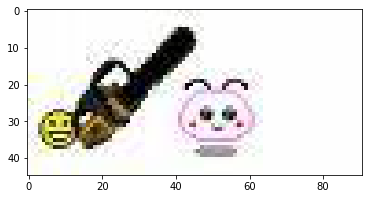

0.1499


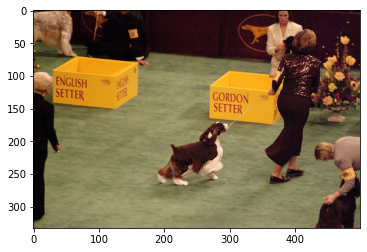

0.0536


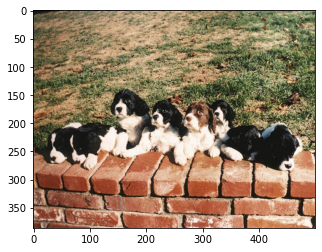

In [13]:
import matplotlib.pyplot as plt

# sort the results, in descending order
positives = positives.sort('preds', reverse=True)

# let's see what the model returned
for record in positives:
    print(round(record['preds'], 4))
    plt.imshow(record['image'])
    plt.show()

These look like great results.

---